# Video Activity Classifier Workshop

In this workshop, we will be training a classifier using body positions extracted from video.

![photo](https://github.com/lisaong/hss/blob/master/assets/istockphoto-476741742.jpg?raw=1)

This follows up from [04_pose_estimation.ipynb](04_pose_estimation.ipynb).

In [0]:
import json
import matplotlib.pyplot as plt
import pandas as pd
import glob
import os
import sys
import numpy as np
from sklearn.metrics.pairwise import paired_distances

# requires: conda install opencv
import cv2

plt.style.use('seaborn-white')

In [0]:
# Source: https://github.com/CMU-Perceptual-Computing-Lab/openpose/blob/master/doc/output.md#pose-output-format-coco
Pose_part_pairs = [
    (1,8), (1,2), (1,5), (2,3), (3,4), (5,6), (6,7), (8,9), (9,10), (10,11),
    (8,12), (12,13), (13,14), (1,0), (0,15), (15,17), (0,16), (16,18), (2,17), (5,18),
    (14,19), (19,20), (14,21), (11,22), (22,23), (11,24)
]

def draw_skeleton(ax, df):
    """Connects keypoints into a skeleton"""
    for p, q in Pose_part_pairs:
        if df.x[p] != 0 and df.x[q] != 0 and df.y[p] != 0 and df.y[q] != 0:
            ax.plot([df.x[p], df.x[q]], [df.y[p], df.y[q]], color='red')

def keypoints_to_dataframe(keypoints):
    """Converts a flat keypoints list (x1, y1, c1, x2, y2, c2) into a pandas DataFrame"""
    return pd.DataFrame({'x': keypoints[::3], 'y': keypoints[1::3], 'c': keypoints[2::3]})

def get_centroid(coordinates, threshold=0.1):
    """Computes the centroid of a given 2 dimensional vector"""
    x = coordinates[coordinates.c > threshold].x
    y = coordinates[coordinates.c > threshold].y
    
    return [sum(x)/len(x), sum(y)/len(y)]

def get_centroids(frame):
    """Returns the centroid for each person as a list of (x, y) coordinates"""
    return np.array([get_centroid(keypoints_to_dataframe(person['pose_keypoints_2d'])) for person in frame['people']])

def get_closest_index(centroid, other_frame):
    """Find closest index in other_frame from a given centroid"""
    other_centroids = get_centroids(other_frame)
    return np.argmin(paired_distances(np.ones(other_centroids.shape) * centroid, other_centroids))

def plot_keypoints(video_path, keypoints_path, frame_first, frame_step, max_frame_last):
    """Displays the keypoints overlaid on the video"""
    video = cv2.VideoCapture(video_path)

    # fast forward video to frame_first
    for i in range(frame_first):
        _, image = video.read()

    frame = json.load(open(f'{keypoints_path}_{frame_first:012d}_keypoints.json', 'rb'))
    df = keypoints_to_dataframe(frame['people'][0]['pose_keypoints_2d'])
    centroid = get_centroid(df)

    # Create the matplotlib axes
    fig, ax = plt.subplots(nrows=3, ncols=2, figsize=(15, 15), sharex=True, sharey=True)
    ax = ax.flatten()

    for i, t in zip(range(len(ax)), range(frame_first, max_frame_last, frame_step)):
        _, image = video.read()

        frame = json.load(open(f'{keypoints_path}_{t:012d}_keypoints.json', 'rb'))
        index = get_closest_index(centroid, frame) # find the closest person

        # load keypoints for the closest person
        df = keypoints_to_dataframe(frame['people'][index]['pose_keypoints_2d'])

        axis = ax[i]
        axis.scatter(df.x, df.y, s=df.c*10, color='yellow')
        axis.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
        axis.set(title=f'Frame {t}')
        draw_skeleton(axis, df)

        centroid = get_centroid(df) # update centroid since person may have moved

## Extract keypoints from the videos using OpenPose

A subset of the keypoints (for the first 10 frames) have been provided. However, we should use more data to train the model.

Follow these steps to extract more keypoints.

1. Modify the paths under `HSS_DIR` and `OPENPOSE_DIR`.

2. Run the code below which calls OpenPoseDemo to extract the keypoints from the data videos.

In [0]:
############# CHANGE BELOW PATH ################
HSS_DIR = r'D:\S-HSS\Workshop\hss'
############# CHANGE ABOVE PATH ################

############# CHANGE BELOW PATH ################
OPENPOSE_DIR = r'D:\S-HSS\Workshop\openpose-1.5.1-binaries-win64-only_cpu-python-flir-3d\openpose'
############# CHANGE ABOVE PATH ################

classes = ['awake', 'sleep']

frame_first = 20
frame_step = 1
frame_last = 50

cwd = os.getcwd()
os.chdir(OPENPOSE_DIR)
for c in classes:
    data_path = os.path.join(HSS_DIR, r'data\dozing', c)
    files = glob.glob(os.path.join(data_path, '*.avi'))
    
    for f in files:
        name, _ = f.split('.')
        input_path = os.path.join(data_path, f)
        output_path = os.path.join(data_path, name)

        cmd = f'bin\\OpenPoseDemo.exe --part_candidates --write_json {output_path} --video {input_path} \
--frame_first {frame_first} --frame_step {frame_step} --frame_last {frame_last}'
        print(cmd)
        os.system(cmd)

os.chdir(cwd)

bin\OpenPoseDemo.exe --part_candidates --write_json D:\S-HSS\Workshop\hss\data\dozing\awake\1 --video D:\S-HSS\Workshop\hss\data\dozing\awake\1.avi         --frame_first 20 --frame_step 1 --frame_last 50
bin\OpenPoseDemo.exe --part_candidates --write_json D:\S-HSS\Workshop\hss\data\dozing\awake\2 --video D:\S-HSS\Workshop\hss\data\dozing\awake\2.avi         --frame_first 20 --frame_step 1 --frame_last 50
bin\OpenPoseDemo.exe --part_candidates --write_json D:\S-HSS\Workshop\hss\data\dozing\awake\3 --video D:\S-HSS\Workshop\hss\data\dozing\awake\3.avi         --frame_first 20 --frame_step 1 --frame_last 50
bin\OpenPoseDemo.exe --part_candidates --write_json D:\S-HSS\Workshop\hss\data\dozing\sleep\1 --video D:\S-HSS\Workshop\hss\data\dozing\sleep\1.avi         --frame_first 20 --frame_step 1 --frame_last 50
bin\OpenPoseDemo.exe --part_candidates --write_json D:\S-HSS\Workshop\hss\data\dozing\sleep\2 --video D:\S-HSS\Workshop\hss\data\dozing\sleep\2.avi         --frame_first 20 --frame_ste

## Examine the keypoints

Plot a sample from each class, with 6 frames and skeleton overlay. 

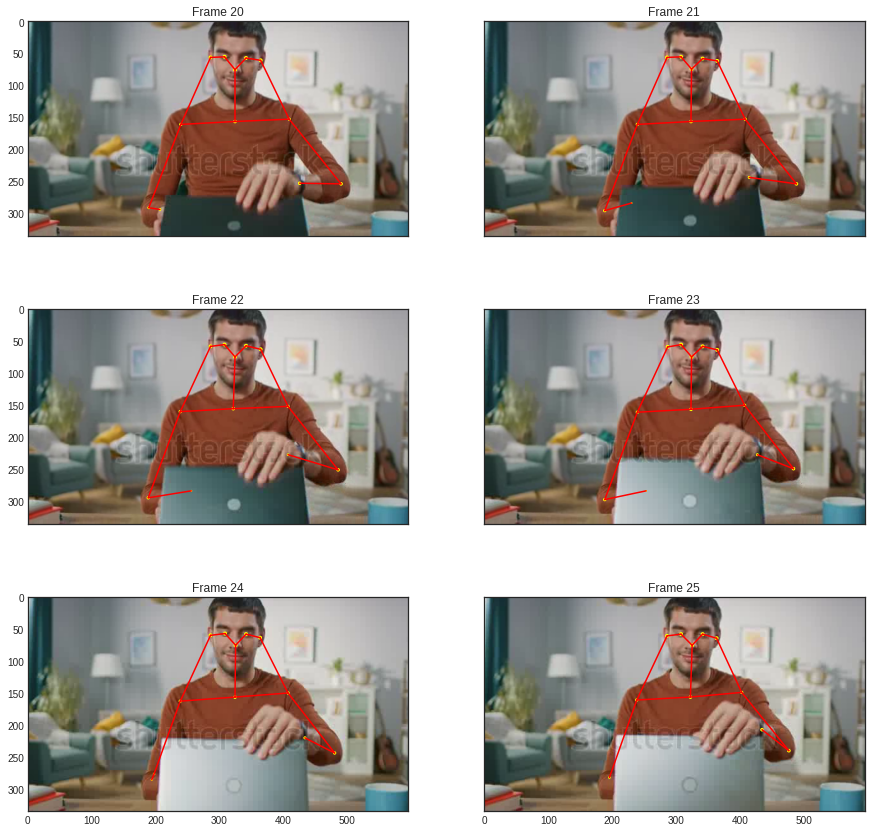

In [18]:
def plot_sample(classname, sample_index):
    """Plots first few frames of a sample video"""
    data_path = os.path.join(HSS_DIR, 'data', 'dozing', classname)
    video_path = os.path.join(data_path, f'{sample_index}.avi')
    keypoints_path = os.path.join(data_path, str(sample_index), str(sample_index))

    frame_first = 20
    frame_step = 1
    frame_last = 50

    plot_keypoints(video_path, keypoints_path, frame_first, frame_step,
                   max_frame_last=frame_last)

plot_sample('awake', 1)

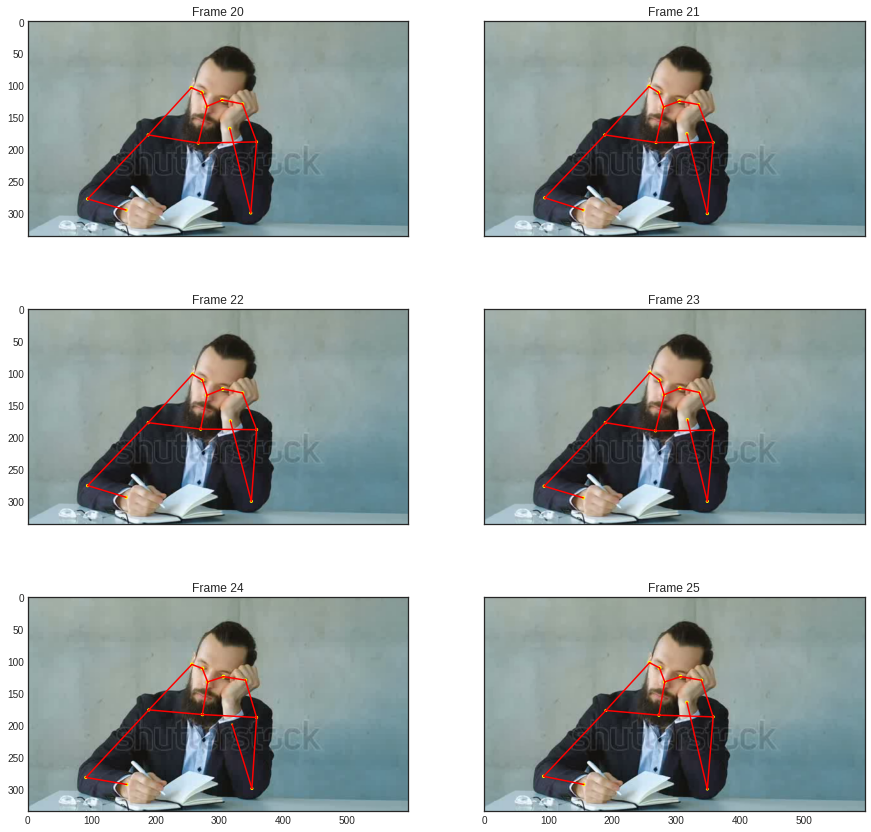

In [19]:
plot_sample('sleep', 1)

## Extract Features

The next step is to convert the keypoints into features for training a model.


In [0]:
def get_part_candidates_as_features(keypoints_path, frame_first, frame_step,
                                    max_frame_last):
    """Convert keypoints into features for body parts

    BODY_25 format:
    https://github.com/CMU-Perceptual-Computing-Lab/openpose/blob/master/doc/output.md#keypoint-ordering-in-cpython
        //     {0,  "Nose"},
        //     {1,  "Neck"},
        //     {2,  "RShoulder"},
        //     {3,  "RElbow"},
        //     {4,  "RWrist"},
        //     {5,  "LShoulder"},
        //     {6,  "LElbow"},
        //     {7,  "LWrist"},
        //     {8,  "MidHip"},
        //     {9,  "RHip"},
        //     {10, "RKnee"},
        //     {11, "RAnkle"},
        //     {12, "LHip"},
        //     {13, "LKnee"},
        //     {14, "LAnkle"},
        //     {15, "REye"},
        //     {16, "LEye"},
        //     {17, "REar"},
        //     {18, "LEar"},
        //     {19, "LBigToe"},
        //     {20, "LSmallToe"},
        //     {21, "LHeel"},
        //     {22, "RBigToe"},
        //     {23, "RSmallToe"},
        //     {24, "RHeel"},
        //     {25, "Background"}

    Result:
        pandas Dataframe: 3 columns for each part, 1 row per frame
        Nose_x, Nose_y, Nose_conf, Neck_x, Neck_y, Neck_confidence, ..    
    """
    PARTS = ["Nose", "Neck", "RShoulder", "RElbow", "RWrist",
             "LShoulder", "LElbow", "LWrist", "MidHip", "RHip",
             "RKnee", "RAnkle", "LHip", "LKnee", "LAnkle", "REye",
             "LEye", "REar", "LEar", "LBigToe", "LSmallToe",
             "LHeel", "RBigToe", "RSmallToe", "RHeel", "Background"] 
    PARTS_INDEX = {PARTS[i]: i for i in range(len(PARTS))}
    
    selected_parts = ["Nose", "Neck", "RWrist", "LWrist"]
    selected_indices = [PARTS_INDEX[p] for p in selected_parts]

    colnames = []
    for p in selected_parts:
        colnames += [f'{p}_x', f'{p}_y', f'{p}_c']

    rows = []

    for t in range(frame_first, max_frame_last, frame_step):
        frame = json.load(open(f'{keypoints_path}_{t:012d}_keypoints.json', 'rb'))
        part_candidates = frame['part_candidates'][0]

        row = []
        # list comprehension can't be used as some part may be missing
        for i in selected_indices:
            part = part_candidates[str(i)]
            if len(part) == 0:
                # part not found
                part = [0, 0, 0]
            row += part[:3] # some parts appear twice, just pick the first entry
        rows.append(row)

    return pd.DataFrame(rows, columns=colnames)

def get_features(classname, sample_index):
    data_path = os.path.join(HSS_DIR, 'data', 'dozing', classname)
    video_path = os.path.join(data_path, f'{sample_index}.avi')
    keypoints_path = os.path.join(data_path, str(sample_index), str(sample_index))

    frame_first = 20
    frame_step = 1
    frame_last = 30

    return get_part_candidates_as_features(keypoints_path, frame_first,
                                    frame_step, max_frame_last=frame_last)

In [81]:
df_awake = get_features('awake', 1)
df_awake.head()

,Nose_x,Nose_y,Nose_c,Neck_x,Neck_y,Neck_c,RShoulder_x,RShoulder_y,RShoulder_c,LShoulder_x,LShoulder_y,LShoulder_c,RWrist_x,RWrist_y,RWrist_c,LWrist_x,LWrist_y,LWrist_c
0,324.448,75.3020,0.852479,324.454,156.549,0.696542,239.605,161.131,0.525105,409.321,152.910,0.476330,206.750,294.360,0.331117,425.768,253.297,0.620195
1,324.442,74.4363,0.846746,323.552,156.544,0.714950,239.586,161.122,0.544044,408.416,152.910,0.507837,230.466,284.299,0.071298,414.814,244.134,0.387848
2,324.444,74.4133,0.844872,321.712,155.615,0.695762,238.685,160.218,0.564244,407.505,151.991,0.499197,256.024,284.314,0.081728,407.517,227.718,0.256929
3,324.458,74.4329,0.846733,323.548,156.529,0.707345,239.578,161.128,0.543937,407.517,150.180,0.531285,253.288,284.323,0.067585,427.589,227.738,0.402218
4,325.383,75.3252,0.869282,324.452,156.559,0.687421,238.669,162.936,0.518828,407.518,150.171,0.530579,193.959,286.143,0.116408,433.961,220.440,0.434289


In [82]:
df_sleep = get_features('sleep', 1)
df_sleep.head()

,Nose_x,Nose_y,Nose_c,Neck_x,Neck_y,Neck_c,RShoulder_x,RShoulder_y,RShoulder_c,LShoulder_x,LShoulder_y,LShoulder_c,RWrist_x,RWrist_y,RWrist_c,LWrist_x,LWrist_y,LWrist_c
0,280.674,132.842,0.825384,266.986,190.325,0.492864,188.481,177.547,0.485188,358.236,188.503,0.431066,153.823,295.243,0.582348,316.252,167.507,0.616363
1,280.690,133.748,0.823432,268.813,189.417,0.493462,188.478,177.534,0.488575,358.237,189.404,0.427996,154.719,295.259,0.566264,317.182,175.711,0.542100
2,280.681,134.628,0.821613,270.637,187.581,0.540141,188.507,177.529,0.475493,358.246,188.503,0.471228,153.805,294.361,0.593509,317.186,174.806,0.540696
3,281.584,133.752,0.834139,267.900,190.301,0.486938,189.389,177.532,0.496043,359.140,189.392,0.415599,154.712,295.268,0.620512,318.060,172.982,0.572065
4,281.564,132.832,0.835369,273.343,183.929,0.567563,189.418,176.635,0.479403,358.240,188.489,0.479206,154.736,293.451,0.555527,317.156,167.498,0.505763


##<font color='red'>Exercise</font>

Currently the body parts selected are "Nose", "Neck", "Right Wrist", and "Left Wrist".

1. Consider whether other body parts are more suitable for distinguishing between the two classes (sleeping or awake).

2. Update `get_features` to use those body parts. Once you are done, re-run the above cells and proceed to the next section to create the dataset.

## Create our dataset

* X - features
* y - target

In [86]:
num_samples = 3

# row-wise concat
df_awake = pd.concat([get_features('awake', i) for i in range(1, num_samples+1)])
df_sleep = pd.concat([get_features('sleep', i) for i in range(1, num_samples+1)])

X = pd.concat([df_awake, df_sleep])
X.shape

(60, 18)

In [87]:
classes = ['awake', 'sleep']
y = np.array([0] * df_awake.shape[0] + [1] * df_sleep.shape[0])
y.shape

(60,)

## Visualise our training set

We will use a technique called PCA to reduce the features into 2 dimensions, then plot the two classes.

This is useful to indicate whether the model used is going perform terribly.


In [0]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

pca = PCA(n_components=2)
scaler = StandardScaler()

X_2d = pca.fit_transform(scaler.fit_transform(X))

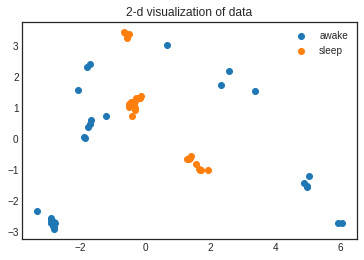

In [90]:
fig, ax = plt.subplots()
ax.set_title('2-d visualization of data')
ax.scatter(X_2d[y==0, 0], X_2d[y==0, 1], label=classes[0])
ax.scatter(X_2d[y==1, 0], X_2d[y==1, 1], label=classes[1])
ax.legend()
plt.show()

In [92]:
# analogous to the degree of 2-d "compression". A high number (close to 1) 
# indicates that the 2-d PCA is non-lossy (so we can trust the above diagram more). 
# 50% is okay

pca.explained_variance_ratio_.sum()

0.5107964591508353

## Random Forest Classifier

Looks like a Random Forest be able to distinguish between the orange and blue samples.

Let's give it a try.

https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html

In [103]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

# Train-test split into test and training sets
# stratify: preserves the proportions of the classes 
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y)

rf = RandomForestClassifier(n_estimators=10, max_depth=3, random_state=25)
rf.fit(X_train, y_train)
rf.score(X_test, y_test)

1.0

In [105]:
# Get predictions from the classifier
y_pred = rf.predict(X_test)

# classification report:
#   support: number of samples in each class
#   accuracy - how many are correct
#   precision - how well the classifier avoided false positives
#   recall - how well the classifier avoided false negatives
#   weighted avg - average weighted based on the proportion of samples in each class
#   macro avg - global average

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         8
           1       1.00      1.00      1.00         7

    accuracy                           1.00        15
   macro avg       1.00      1.00      1.00        15
weighted avg       1.00      1.00      1.00        15



In [108]:
X_test

,Nose_x,Nose_y,Nose_c,Neck_x,Neck_y,Neck_c,RShoulder_x,RShoulder_y,RShoulder_c,LShoulder_x,LShoulder_y,LShoulder_c,RWrist_x,RWrist_y,RWrist_c,LWrist_x,LWrist_y,LWrist_c
4,325.383,75.3252,0.869282,324.452,156.559,0.687421,238.669,162.936,0.518828,407.518,150.171,0.530579,193.959,286.143,0.116408,433.961,220.440,0.434289
5,325.358,105.4260,0.822746,308.046,157.468,0.725914,234.131,157.480,0.517218,378.308,153.829,0.568737,268.811,274.262,0.491982,0.000,0.000,0.000000
9,370.085,109.1080,0.845776,287.041,177.546,0.510100,220.432,166.601,0.434084,345.467,191.213,0.349175,358.240,323.559,0.069392,371.915,162.923,0.674018
0,318.095,107.2530,0.842556,308.923,158.389,0.704379,234.126,158.383,0.499380,380.135,155.618,0.567151,267.867,275.168,0.435597,0.000,0.000,0.000000
2,208.578,68.9552,0.908176,185.754,157.445,0.565668,115.480,152.905,0.469427,256.933,167.506,0.256632,212.208,252.392,0.273845,242.331,144.679,0.513667
8,324.455,79.9041,0.840533,320.834,154.730,0.711729,241.404,162.917,0.571999,397.476,145.611,0.486955,194.888,287.058,0.139095,427.588,199.451,0.268064
0,372.845,108.2060,0.837833,287.044,174.814,0.533602,222.263,164.765,0.438347,350.927,186.663,0.329377,361.887,323.542,0.144381,374.639,162.022,0.632756
9,324.464,83.5191,0.861289,320.793,155.612,0.723446,241.416,162.943,0.575212,399.286,145.604,0.476630,197.623,285.215,0.179196,0.000,0.000,0.000000
0,331.754,119.7840,0.818662,161.865,134.347,0.146232,148.967,132.645,0.126530,176.410,136.074,0.075274,249.364,251.929,0.532390,335.196,259.653,0.485038
1,318.979,108.1720,0.831142,308.931,158.370,0.708882,235.041,158.373,0.499257,381.028,154.743,0.559822,267.875,274.265,0.456302,0.000,0.000,0.000000


In [106]:
y_test

array([0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1])

In [107]:
y_pred

array([0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1])

## <font color='red'> Exercise </font>

1. Instead of asleep vs. awake, replace the videos with two other types of activity.

2. Train a classifier to predict between your chosen activities.

### <font color='red'> Submission </font>
Submit your modified .ipynb to the Workshop 4 folder by the submission deadline.